# APE section #
Here I will describe all the required steps

## 0. Install all required dependencies and imports ##
I will add to this list as they are required

In [ ]:
# imports
# working with the drive
from google.colab import drive
from google.colab import files #potentially remove later

# working with data
import zipfile #potentially remove later
import shutil #potentially remove later (for uploading zip to drive)
import os
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from glob import glob

# Neural network things
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPool2D, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.model_selection import train_test_split

## 1. Get the data on the notebook ##
mount the drive

Get the pose data set. To do this, you need to make a shortcut to a shared Google Drive directory in your Google Drive.

1.   Go to the shared Google Drive: [https://drive.google.com/drive/folders/1a06ZAmQXvUqZZQGI9XWWjABl4vOF8v6Z?usp=sharing](https://drive.google.com/drive/folders/1a06ZAmQXvUqZZQGI9XWWjABl4vOF8v6Z?usp=sharing)
2.   Select "Add shortcut to Drive" and select "My Drive".

![picture](https://drive.google.com/file/d/1S5ls_xk1R7tB6Y5q32YMVSrBwuTwXO_Q/cd?usp=drive_link)


## 2. Data Preperations##
I need to extract the data for the files and save them in a ordered format on the colab. That is a single folder with all the images with unique names. Then another folder with all annotations and a list with all the ids

### 2.1. Load Data ###
Now that the images and annotations have been saved to the drive, we must be able to retreive them

In [ ]:
# mount drive
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
# unzip image data - this may take a couple of minutes to run
def unzip(zip_file_path):
    # Check if the zip file exists
    if not os.path.exists(zip_file_path):
        print("Zip file not found.")
        return

    # Unzipping the file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall()  # Extracts to the current working directory

    print(f"Unzipped files from {zip_file_path} to the current directory.")

# Example usage
zip_file_path = '/content/drive/MyDrive/APELectureDataAllImages/images.zip'  # Replace with your zip file path
unzip(zip_file_path)

Unzipped files from /content/drive/MyDrive/APELectureDataAllImages/images.zip to the current directory.


In [ ]:
# copy the annotation data to the working directory
def copy_file_to_working_directory(file_path):
    # Extract the file name from the file path
    file_name = os.path.basename(file_path)

    # Copy the file to the current directory
    shutil.copy(file_path, file_name)

    print(f"Copied {file_path} to the current directory as {file_name}.")

# Example usage
file_path = '/content/drive/MyDrive/APELectureDataAllImages/combined_data.csv'  # Replace with your file path
copy_file_to_working_directory(file_path)

Copied /content/drive/MyDrive/APELectureDataAllImages/combined_data.csv to the current directory as combined_data.csv.


In [ ]:
# check that the number of annotations matches the number of images
image_folder = '/content/images'
print('number of images:')
print(len([name for name in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, name))]))
csv_path = '/content/combined_data.csv'
print('number of annotations:')
df = pd.read_csv(csv_path)
print(len(df)-3) # subtract 3 because there are 4 header rows and the len() function only counts the first row as a header
#print(df.head(4)) # this prints out the first 4 rows to show that row 0, 1, 2 contain header info

number of images:
2044
number of annotations:
2044


View the df to check out what the data looks like

In [ ]:
df.head(5)

,scorer,Unnamed: 1_level_0,Unnamed: 2_level_0,Ro,Ro.1,Ro.2,Ro.3,Ro.4,Ro.5,Ro.6,...,Ro.18,Ro.19,Ro.20,Ro.21,Ro.22,Ro.23,Ro.24,Ro.25,Ro.26,Ro.27
0,individuals,Unnamed: 1_level_1,Unnamed: 2_level_1,ID1,ID1,ID1,ID1,ID1,ID1,ID1,...,ID1,ID1,ID1,ID1,ID1,ID1,ID1,ID1,ID1,ID1
1,bodyparts,Unnamed: 1_level_2,Unnamed: 2_level_2,Head,Head,Beak,Beak,Body_top,Body_top,RFlipper_top,...,Body_mid,Body_mid,Body_bottom,Body_bottom,Tail_tip,Tail_tip,RFoot,RFoot,LFoot,LFoot
2,coords,Unnamed: 1_level_3,Unnamed: 2_level_3,x,y,x,y,x,y,x,...,x,y,x,y,x,y,x,y,x,y
3,labeled-data,flap6c,img005.png,1015.8624760689218,372.6203573707724,1110.7444160816851,478.75947670708376,771.4208679004469,432.1225909380984,885.6008296107213,...,620.2530312699428,592.9394384173581,633.1183790682835,863.1117421825145,610.6040204211872,994.9815571155076,NaN,NaN,NaN,NaN
4,labeled-data,flap6c,img024.png,892.0335035098917,239.1423739629868,975.658264199107,334.0243139757499,760.1636885768987,419.2572431397576,908.115188257818,...,658.8490746649651,633.143650287173,692.6206126356096,829.3402042118701,719.9594767070839,933.8711550733888,NaN,NaN,642.7673899170392,1001.414231014678


### 2.2. Adjust DataFrame by removing unnecessary rows and columns. Create a image ID column that has the same naming convension as our downloaded images

In [ ]:
# remove the first 3 header rows
df = df.iloc[3:]

# creating an ID column that has the same naming convension as the images
df['image_id'] = df.iloc[:, 1] + '_' + df.iloc[:, 2]

<ipython-input-9-cbfee5fd1020>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image_id'] = df.iloc[:, 1] + '_' + df.iloc[:, 2]


View the new df structure

In [ ]:
df.head(5)

,scorer,Unnamed: 1_level_0,Unnamed: 2_level_0,Ro,Ro.1,Ro.2,Ro.3,Ro.4,Ro.5,Ro.6,...,Ro.19,Ro.20,Ro.21,Ro.22,Ro.23,Ro.24,Ro.25,Ro.26,Ro.27,image_id
3,labeled-data,flap6c,img005.png,1015.8624760689218,372.6203573707724,1110.7444160816851,478.75947670708376,771.4208679004469,432.1225909380984,885.6008296107213,...,592.9394384173581,633.1183790682835,863.1117421825145,610.6040204211872,994.9815571155076,NaN,NaN,NaN,NaN,flap6c_img005.png
4,labeled-data,flap6c,img024.png,892.0335035098917,239.1423739629868,975.658264199107,334.0243139757499,760.1636885768987,419.2572431397576,908.115188257818,...,633.143650287173,692.6206126356096,829.3402042118701,719.9594767070839,933.8711550733888,NaN,NaN,642.7673899170392,1001.414231014678,flap6c_img024.png
5,labeled-data,flap6c,img039.png,872.7354818123806,218.23618379068284,NaN,NaN,835.7476068921508,391.91837906828346,962.792916400766,...,649.2253350350991,745.6901723037654,826.1238672622849,719.9594767070839,967.6426930440334,NaN,NaN,681.3634333120615,980.5080408423742,flap6c_img039.png
6,labeled-data,flap6c,img062.png,700.6614550095726,198.9381620931717,NaN,NaN,715.1349712827059,385.4857051691131,874.3436502871732,...,625.1028079132101,729.6084875558395,826.1238672622849,710.3104658583281,956.3855137204852,NaN,NaN,655.6327377153799,1001.414231014678,flap6c_img062.png
7,labeled-data,flap6c,img065.png,729.6084875558395,200.54633056796436,NaN,NaN,747.298340778558,391.91837906828346,892.0335035098917,...,628.3191448627953,747.298340778558,803.6095086151884,747.298340778558,900.0996171027443,NaN,NaN,676.5389278876837,974.0753669432038,flap6c_img065.png


In [ ]:
# remove the first 3 columns that hold no useful information
df = df.iloc[:, 3:]

In [ ]:
df.head(5)

,Ro,Ro.1,Ro.2,Ro.3,Ro.4,Ro.5,Ro.6,Ro.7,Ro.8,Ro.9,...,Ro.19,Ro.20,Ro.21,Ro.22,Ro.23,Ro.24,Ro.25,Ro.26,Ro.27,image_id
3,1015.8624760689218,372.6203573707724,1110.7444160816851,478.75947670708376,771.4208679004469,432.1225909380984,885.6008296107213,610.6292916400768,NaN,NaN,...,592.9394384173581,633.1183790682835,863.1117421825145,610.6040204211872,994.9815571155076,NaN,NaN,NaN,NaN,flap6c_img005.png
4,892.0335035098917,239.1423739629868,975.658264199107,334.0243139757499,760.1636885768987,419.2572431397576,908.115188257818,570.4250797702617,NaN,NaN,...,633.143650287173,692.6206126356096,829.3402042118701,719.9594767070839,933.8711550733888,NaN,NaN,642.7673899170392,1001.414231014678,flap6c_img024.png
5,872.7354818123806,218.23618379068284,NaN,NaN,835.7476068921508,391.91837906828346,962.792916400766,525.396362476069,NaN,NaN,...,649.2253350350991,745.6901723037654,826.1238672622849,719.9594767070839,967.6426930440334,NaN,NaN,681.3634333120615,980.5080408423742,flap6c_img039.png
6,700.6614550095726,198.9381620931717,NaN,NaN,715.1349712827059,385.4857051691131,874.3436502871732,515.7473516273135,599.346841097639,520.5718570516913,...,625.1028079132101,729.6084875558395,826.1238672622849,710.3104658583281,956.3855137204852,NaN,NaN,655.6327377153799,1001.414231014678,flap6c_img062.png
7,729.6084875558395,200.54633056796436,NaN,NaN,747.298340778558,391.91837906828346,892.0335035098917,512.5310146777283,621.8611997447354,523.7881940012765,...,628.3191448627953,747.298340778558,803.6095086151884,747.298340778558,900.0996171027443,NaN,NaN,676.5389278876837,974.0753669432038,flap6c_img065.png


### 2.3. Convert keypoints from strings to floats so we can work with them

In [ ]:
# create list with keypoint col names so we can iterate through them when needed
columns = df.iloc[:, :-1].columns.tolist()

In [ ]:
print(columns)

['Ro', 'Ro.1', 'Ro.2', 'Ro.3', 'Ro.4', 'Ro.5', 'Ro.6', 'Ro.7', 'Ro.8', 'Ro.9', 'Ro.10', 'Ro.11', 'Ro.12', 'Ro.13', 'Ro.14', 'Ro.15', 'Ro.16', 'Ro.17', 'Ro.18', 'Ro.19', 'Ro.20', 'Ro.21', 'Ro.22', 'Ro.23', 'Ro.24', 'Ro.25', 'Ro.26', 'Ro.27']


In [ ]:
# the keypoints are currently strings. They must be converted to float to be useable
def df_convert_keypoints_to_float(df, columns):
  df_adjusted = df.copy()
    # Iterate over the specified columns
  for col in columns:
      # Convert the column to float
      df_adjusted[col] = df_adjusted[col].astype(np.float32)
  return df_adjusted

df = df_convert_keypoints_to_float(df, columns)

In [ ]:
# check that the data type was changed successfully
print(df.dtypes)

Ro          float32
Ro.1        float32
Ro.2        float32
Ro.3        float32
Ro.4        float32
Ro.5        float32
Ro.6        float32
Ro.7        float32
Ro.8        float32
Ro.9        float32
Ro.10       float32
Ro.11       float32
Ro.12       float32
Ro.13       float32
Ro.14       float32
Ro.15       float32
Ro.16       float32
Ro.17       float32
Ro.18       float32
Ro.19       float32
Ro.20       float32
Ro.21       float32
Ro.22       float32
Ro.23       float32
Ro.24       float32
Ro.25       float32
Ro.26       float32
Ro.27       float32
image_id     object
dtype: object


### 2.3.2 Remove data with more than 50% of the keypoints missing

In [ ]:
df.shape

(2044, 29)

In [ ]:
# removing any examples with more NaN values than the chosen threshold
# The nan values are there when a keypoint is occluded

def remove_rows_with_too_many_nans(df, columns_to_check, nan_threshold):
    """
    Remove rows from the DataFrame where the number of NaN values in specified columns exceeds the threshold.

    Parameters:
    - df: The DataFrame to process.
    - columns_to_check: A list of column names to check for NaN values.
    - nan_threshold: The maximum allowed number of NaN values in the specified columns. Rows with more NaNs will be removed.

    Returns:
    - A new DataFrame with rows exceeding the NaN threshold removed.
    """
    # Count NaNs only in the specified columns
    nan_counts = df[columns_to_check].isna().sum(axis=1)

    # Identify rows where NaN count is below or equal to the threshold
    rows_to_keep = nan_counts <= nan_threshold

    # Filter the DataFrame to keep only the desired rows
    filtered_df = df[rows_to_keep]

    return filtered_df


In [ ]:
# calling the function to remove the rows with more than 14 keypoint coords missing
# the number of keypoints is 14 and each has 2 coords so there are 28 coords
df = remove_rows_with_too_many_nans(df, columns, 14)

In [ ]:
df.shape

(1964, 29)

### 2.4. Finding the bounding box coordinates
 normally this would be determined by a detection algorithm  

In [ ]:
# First lets adjust our keypoints column name list to have two lists:
# One with the column names of the columns with x coords and one with the y coords
col_x = columns[0::2]
col_y = columns[1::2]

In [ ]:
print(columns)

['Ro', 'Ro.1', 'Ro.2', 'Ro.3', 'Ro.4', 'Ro.5', 'Ro.6', 'Ro.7', 'Ro.8', 'Ro.9', 'Ro.10', 'Ro.11', 'Ro.12', 'Ro.13', 'Ro.14', 'Ro.15', 'Ro.16', 'Ro.17', 'Ro.18', 'Ro.19', 'Ro.20', 'Ro.21', 'Ro.22', 'Ro.23', 'Ro.24', 'Ro.25', 'Ro.26', 'Ro.27']


In [ ]:
print(col_x)

['Ro', 'Ro.2', 'Ro.4', 'Ro.6', 'Ro.8', 'Ro.10', 'Ro.12', 'Ro.14', 'Ro.16', 'Ro.18', 'Ro.20', 'Ro.22', 'Ro.24', 'Ro.26']


In [ ]:
print(col_y)

['Ro.1', 'Ro.3', 'Ro.5', 'Ro.7', 'Ro.9', 'Ro.11', 'Ro.13', 'Ro.15', 'Ro.17', 'Ro.19', 'Ro.21', 'Ro.23', 'Ro.25', 'Ro.27']


#### 2.4.1. Find the x lower and upper bound and y lower and upper bound and attach them as col

In [ ]:
# here we need to create a bounding box around the penguins.
# We are first finding the extreme keypoints as the bounding box will be slightly bigger than that
# Finding the smallest and largest x keypoint coord, and the same for the y
def find_lower_and_upper_bound(row, col_name):

    # get the relevant coords
    coords = row[col_name]
    # find the lower bound
    lower_bound = coords.min()
    # find upper bound
    upper_bound = coords.max()

    if col_name[0] == 'Ro':
      x_or_y = 'x'
    else:
      x_or_y = 'y'

    index_lower = x_or_y + '_lower'
    index_upper = x_or_y + '_upper'

    return pd.Series([lower_bound, upper_bound], index=[index_lower, index_upper])


In [ ]:
new_columns_x = df.apply(find_lower_and_upper_bound, col_name=col_x, axis=1)


In [ ]:
new_columns_x.head(5)

,x_lower,x_upper
3,610.604004,1110.744385
4,642.767395,975.658264
5,681.363403,990.131775
6,501.248566,930.629517
7,494.815887,974.050110


In [ ]:
df = pd.concat([df, new_columns_x], axis=1)

In [ ]:
df.head(5)

,Ro,Ro.1,Ro.2,Ro.3,Ro.4,Ro.5,Ro.6,Ro.7,Ro.8,Ro.9,...,Ro.21,Ro.22,Ro.23,Ro.24,Ro.25,Ro.26,Ro.27,image_id,x_lower,x_upper
3,1015.862488,372.620361,1110.744385,478.759491,771.420837,432.122589,885.600830,610.629272,NaN,NaN,...,863.111755,610.604004,994.981567,NaN,NaN,NaN,NaN,flap6c_img005.png,610.604004,1110.744385
4,892.033508,239.142380,975.658264,334.024323,760.163696,419.257233,908.115173,570.425110,NaN,NaN,...,829.340210,719.959473,933.871155,NaN,NaN,642.767395,1001.414246,flap6c_img024.png,642.767395,975.658264
5,872.735474,218.236191,NaN,NaN,835.747620,391.918365,962.792908,525.396362,NaN,NaN,...,826.123840,719.959473,967.642700,NaN,NaN,681.363403,980.508057,flap6c_img039.png,681.363403,990.131775
6,700.661438,198.938156,NaN,NaN,715.134949,385.485718,874.343628,515.747375,599.346863,520.571838,...,826.123840,710.310486,956.385498,NaN,NaN,655.632751,1001.414246,flap6c_img062.png,501.248566,930.629517
7,729.608459,200.546326,NaN,NaN,747.298340,391.918365,892.033508,512.531006,621.861206,523.788208,...,803.609497,747.298340,900.099609,NaN,NaN,676.538940,974.075378,flap6c_img065.png,494.815887,974.050110


In [ ]:
new_columns_y = df.apply(find_lower_and_upper_bound, col_name=col_y, axis=1)

In [ ]:
new_columns_y.head(5)

,y_lower,y_upper
3,372.620361,994.981567
4,239.142380,1001.414246
5,218.236191,980.508057
6,198.938156,1001.414246
7,200.546326,974.075378


In [ ]:
df = pd.concat([df, new_columns_y], axis=1)

In [ ]:
df.head(5)

,Ro,Ro.1,Ro.2,Ro.3,Ro.4,Ro.5,Ro.6,Ro.7,Ro.8,Ro.9,...,Ro.23,Ro.24,Ro.25,Ro.26,Ro.27,image_id,x_lower,x_upper,y_lower,y_upper
3,1015.862488,372.620361,1110.744385,478.759491,771.420837,432.122589,885.600830,610.629272,NaN,NaN,...,994.981567,NaN,NaN,NaN,NaN,flap6c_img005.png,610.604004,1110.744385,372.620361,994.981567
4,892.033508,239.142380,975.658264,334.024323,760.163696,419.257233,908.115173,570.425110,NaN,NaN,...,933.871155,NaN,NaN,642.767395,1001.414246,flap6c_img024.png,642.767395,975.658264,239.142380,1001.414246
5,872.735474,218.236191,NaN,NaN,835.747620,391.918365,962.792908,525.396362,NaN,NaN,...,967.642700,NaN,NaN,681.363403,980.508057,flap6c_img039.png,681.363403,990.131775,218.236191,980.508057
6,700.661438,198.938156,NaN,NaN,715.134949,385.485718,874.343628,515.747375,599.346863,520.571838,...,956.385498,NaN,NaN,655.632751,1001.414246,flap6c_img062.png,501.248566,930.629517,198.938156,1001.414246
7,729.608459,200.546326,NaN,NaN,747.298340,391.918365,892.033508,512.531006,621.861206,523.788208,...,900.099609,NaN,NaN,676.538940,974.075378,flap6c_img065.png,494.815887,974.050110,200.546326,974.075378


#### 2.4.2. FInd the centre point and the image crop width and height (upper minus lower bounds) and save them as a col

In [ ]:
# first find the centre point of the upper and lower x_coord
df['x_centre'] = ((df['x_upper'] - df['x_lower'])/2)+ df['x_lower']

In [ ]:
df.head(3)

,Ro,Ro.1,Ro.2,Ro.3,Ro.4,Ro.5,Ro.6,Ro.7,Ro.8,Ro.9,...,Ro.24,Ro.25,Ro.26,Ro.27,image_id,x_lower,x_upper,y_lower,y_upper,x_centre
3,1015.862488,372.620361,1110.744385,478.759491,771.420837,432.122589,885.600830,610.629272,NaN,NaN,...,NaN,NaN,NaN,NaN,flap6c_img005.png,610.604004,1110.744385,372.620361,994.981567,860.674194
4,892.033508,239.142380,975.658264,334.024323,760.163696,419.257233,908.115173,570.425110,NaN,NaN,...,NaN,NaN,642.767395,1001.414246,flap6c_img024.png,642.767395,975.658264,239.142380,1001.414246,809.212830
5,872.735474,218.236191,NaN,NaN,835.747620,391.918365,962.792908,525.396362,NaN,NaN,...,NaN,NaN,681.363403,980.508057,flap6c_img039.png,681.363403,990.131775,218.236191,980.508057,835.747589


In [ ]:
# then find the centre point of the upper and lower y_coord
df['y_centre'] = ((df['y_upper'] - df['y_lower'])/2)+ df['y_lower']

In [ ]:
df.head(3)

,Ro,Ro.1,Ro.2,Ro.3,Ro.4,Ro.5,Ro.6,Ro.7,Ro.8,Ro.9,...,Ro.25,Ro.26,Ro.27,image_id,x_lower,x_upper,y_lower,y_upper,x_centre,y_centre
3,1015.862488,372.620361,1110.744385,478.759491,771.420837,432.122589,885.600830,610.629272,NaN,NaN,...,NaN,NaN,NaN,flap6c_img005.png,610.604004,1110.744385,372.620361,994.981567,860.674194,683.800964
4,892.033508,239.142380,975.658264,334.024323,760.163696,419.257233,908.115173,570.425110,NaN,NaN,...,NaN,642.767395,1001.414246,flap6c_img024.png,642.767395,975.658264,239.142380,1001.414246,809.212830,620.278313
5,872.735474,218.236191,NaN,NaN,835.747620,391.918365,962.792908,525.396362,NaN,NaN,...,NaN,681.363403,980.508057,flap6c_img039.png,681.363403,990.131775,218.236191,980.508057,835.747589,599.372124


In [ ]:
# now find the width of the bounding box (upper_x - lower_x)
df['width'] = df['x_upper'] - df['x_lower']

In [ ]:
df.head(3)

,Ro,Ro.1,Ro.2,Ro.3,Ro.4,Ro.5,Ro.6,Ro.7,Ro.8,Ro.9,...,Ro.26,Ro.27,image_id,x_lower,x_upper,y_lower,y_upper,x_centre,y_centre,width
3,1015.862488,372.620361,1110.744385,478.759491,771.420837,432.122589,885.600830,610.629272,NaN,NaN,...,NaN,NaN,flap6c_img005.png,610.604004,1110.744385,372.620361,994.981567,860.674194,683.800964,500.140381
4,892.033508,239.142380,975.658264,334.024323,760.163696,419.257233,908.115173,570.425110,NaN,NaN,...,642.767395,1001.414246,flap6c_img024.png,642.767395,975.658264,239.142380,1001.414246,809.212830,620.278313,332.890869
5,872.735474,218.236191,NaN,NaN,835.747620,391.918365,962.792908,525.396362,NaN,NaN,...,681.363403,980.508057,flap6c_img039.png,681.363403,990.131775,218.236191,980.508057,835.747589,599.372124,308.768372


In [ ]:
# now find the height of the bounding box (upper_y - lower_y)
df['height'] = df['y_upper'] - df['y_lower']

In [ ]:
df.head(3)

,Ro,Ro.1,Ro.2,Ro.3,Ro.4,Ro.5,Ro.6,Ro.7,Ro.8,Ro.9,...,Ro.27,image_id,x_lower,x_upper,y_lower,y_upper,x_centre,y_centre,width,height
3,1015.862488,372.620361,1110.744385,478.759491,771.420837,432.122589,885.600830,610.629272,NaN,NaN,...,NaN,flap6c_img005.png,610.604004,1110.744385,372.620361,994.981567,860.674194,683.800964,500.140381,622.361206
4,892.033508,239.142380,975.658264,334.024323,760.163696,419.257233,908.115173,570.425110,NaN,NaN,...,1001.414246,flap6c_img024.png,642.767395,975.658264,239.142380,1001.414246,809.212830,620.278313,332.890869,762.271866
5,872.735474,218.236191,NaN,NaN,835.747620,391.918365,962.792908,525.396362,NaN,NaN,...,980.508057,flap6c_img039.png,681.363403,990.131775,218.236191,980.508057,835.747589,599.372124,308.768372,762.271866


#### 2.4.3. take the larger of the crop width and height, add 20% and save this as box_size. This will be used to crop a square image

In [ ]:
# We need to find the max value of the width and height
# then add 20% on that size and save it as a column 'box_size'
def calculate_box_size(row):

    # Select the width and height columns
    selected_values = row[['width', 'height']]

    # Calculate the max value
    max_value = selected_values.max()

    # add 20%
    max_value_20 = max_value + (max_value * 0.2)

    return max_value_20

In [ ]:
df['box_size'] = df.apply(calculate_box_size, axis=1)

In [ ]:
df.head(3)

,Ro,Ro.1,Ro.2,Ro.3,Ro.4,Ro.5,Ro.6,Ro.7,Ro.8,Ro.9,...,image_id,x_lower,x_upper,y_lower,y_upper,x_centre,y_centre,width,height,box_size
3,1015.862488,372.620361,1110.744385,478.759491,771.420837,432.122589,885.600830,610.629272,NaN,NaN,...,flap6c_img005.png,610.604004,1110.744385,372.620361,994.981567,860.674194,683.800964,500.140381,622.361206,746.833447
4,892.033508,239.142380,975.658264,334.024323,760.163696,419.257233,908.115173,570.425110,NaN,NaN,...,flap6c_img024.png,642.767395,975.658264,239.142380,1001.414246,809.212830,620.278313,332.890869,762.271866,914.726239
5,872.735474,218.236191,NaN,NaN,835.747620,391.918365,962.792908,525.396362,NaN,NaN,...,flap6c_img039.png,681.363403,990.131775,218.236191,980.508057,835.747589,599.372124,308.768372,762.271866,914.726239


#### 2.4.4. Shifting the keypoints so that the values align with the bounding box

In [ ]:
# find the x shift required for the keypoints:
# x_centre - half box_size
# and save in col x_shift
df['x_shift'] = df['x_centre'] - (df['box_size']/2)

In [ ]:
df.head(3)

,Ro,Ro.1,Ro.2,Ro.3,Ro.4,Ro.5,Ro.6,Ro.7,Ro.8,Ro.9,...,x_lower,x_upper,y_lower,y_upper,x_centre,y_centre,width,height,box_size,x_shift
3,1015.862488,372.620361,1110.744385,478.759491,771.420837,432.122589,885.600830,610.629272,NaN,NaN,...,610.604004,1110.744385,372.620361,994.981567,860.674194,683.800964,500.140381,622.361206,746.833447,487.257471
4,892.033508,239.142380,975.658264,334.024323,760.163696,419.257233,908.115173,570.425110,NaN,NaN,...,642.767395,975.658264,239.142380,1001.414246,809.212830,620.278313,332.890869,762.271866,914.726239,351.849710
5,872.735474,218.236191,NaN,NaN,835.747620,391.918365,962.792908,525.396362,NaN,NaN,...,681.363403,990.131775,218.236191,980.508057,835.747589,599.372124,308.768372,762.271866,914.726239,378.384470


In [ ]:
# find the y shift required for the keypoints:
# y_centre - half box_size
# and save in col y_shift
df['y_shift'] = df['y_centre'] - (df['box_size']/2)

In [ ]:
df.head(3)

,Ro,Ro.1,Ro.2,Ro.3,Ro.4,Ro.5,Ro.6,Ro.7,Ro.8,Ro.9,...,x_upper,y_lower,y_upper,x_centre,y_centre,width,height,box_size,x_shift,y_shift
3,1015.862488,372.620361,1110.744385,478.759491,771.420837,432.122589,885.600830,610.629272,NaN,NaN,...,1110.744385,372.620361,994.981567,860.674194,683.800964,500.140381,622.361206,746.833447,487.257471,310.384241
4,892.033508,239.142380,975.658264,334.024323,760.163696,419.257233,908.115173,570.425110,NaN,NaN,...,975.658264,239.142380,1001.414246,809.212830,620.278313,332.890869,762.271866,914.726239,351.849710,162.915193
5,872.735474,218.236191,NaN,NaN,835.747620,391.918365,962.792908,525.396362,NaN,NaN,...,990.131775,218.236191,980.508057,835.747589,599.372124,308.768372,762.271866,914.726239,378.384470,142.009004


In [ ]:
# shift the coords
# take all coords and minus shift for that row

def shift_keypoints(df, columns):

  # save an copy of the df to adjust
  df_adjusted = df.copy()

  # check if we are dealing with x or y
  if columns[0] == 'Ro':
    x_or_y = 'x'
  else:
    x_or_y = 'y'

  shift = x_or_y + '_shift'

  # Iterate over the specified columns
  for col in columns:
      # shift keypoints by the relevant shift value
      df_adjusted[col] = df_adjusted[col] - df_adjusted[shift]

  return df_adjusted

In [ ]:
# shift the x coords of the keypoints
df = shift_keypoints(df, col_x)

In [ ]:
df.head(3)

,Ro,Ro.1,Ro.2,Ro.3,Ro.4,Ro.5,Ro.6,Ro.7,Ro.8,Ro.9,...,x_upper,y_lower,y_upper,x_centre,y_centre,width,height,box_size,x_shift,y_shift
3,528.605017,372.620361,623.486914,478.759491,284.163367,432.122589,398.343359,610.629272,NaN,NaN,...,1110.744385,372.620361,994.981567,860.674194,683.800964,500.140381,622.361206,746.833447,487.257471,310.384241
4,540.183798,239.142380,623.808554,334.024323,408.313986,419.257233,556.265463,570.425110,NaN,NaN,...,975.658264,239.142380,1001.414246,809.212830,620.278313,332.890869,762.271866,914.726239,351.849710,162.915193
5,494.351004,218.236191,NaN,NaN,457.363150,391.918365,584.408438,525.396362,NaN,NaN,...,990.131775,218.236191,980.508057,835.747589,599.372124,308.768372,762.271866,914.726239,378.384470,142.009004


In [ ]:
# shift the y coords of the keypoints
df = shift_keypoints(df, col_y)

In [ ]:
df.head(3)

,Ro,Ro.1,Ro.2,Ro.3,Ro.4,Ro.5,Ro.6,Ro.7,Ro.8,Ro.9,...,x_upper,y_lower,y_upper,x_centre,y_centre,width,height,box_size,x_shift,y_shift
3,528.605017,62.236121,623.486914,168.375250,284.163367,121.738348,398.343359,300.245032,NaN,NaN,...,1110.744385,372.620361,994.981567,860.674194,683.800964,500.140381,622.361206,746.833447,487.257471,310.384241
4,540.183798,76.227187,623.808554,171.109129,408.313986,256.342039,556.265463,407.509917,NaN,NaN,...,975.658264,239.142380,1001.414246,809.212830,620.278313,332.890869,762.271866,914.726239,351.849710,162.915193
5,494.351004,76.227187,NaN,NaN,457.363150,249.909361,584.408438,383.387358,NaN,NaN,...,990.131775,218.236191,980.508057,835.747589,599.372124,308.768372,762.271866,914.726239,378.384470,142.009004


### 2.5. Normalise keypoints

In [ ]:
# This function will normalise the keypoints to values between [-1, 1]
def df_norm_keypoints(df, columns):

    df_adjusted = df.copy()

    # Calculate the values to adjust the keypoints by so that they are normalised between [-1, 1]
    adjust_value = df_adjusted['box_size']/2

    # Iterate over the specified columns
    for col in columns:

        # normalise the keypoint values by adjusting the keypoint values
        df_adjusted[col] = (df_adjusted[col] - adjust_value) / adjust_value

    return df_adjusted

In [ ]:
# call the normalisation function and apply it to the keypoint cols
df = df_norm_keypoints(df, columns)

In [ ]:
df.head(3)

,Ro,Ro.1,Ro.2,Ro.3,Ro.4,Ro.5,Ro.6,Ro.7,Ro.8,Ro.9,...,x_upper,y_lower,y_upper,x_centre,y_centre,width,height,box_size,x_shift,y_shift
3,0.415590,-0.833333,0.669681,-0.549096,-2.390181e-01,-0.673988,0.066753,-0.195952,NaN,NaN,...,1110.744385,372.620361,994.981567,860.674194,683.800964,500.140381,622.361206,746.833447,487.257471,310.384241
4,0.181083,-0.833333,0.363924,-0.625879,-1.072433e-01,-0.439522,0.216245,-0.109001,NaN,NaN,...,975.658264,239.142380,1001.414246,809.212830,620.278313,332.890869,762.271866,914.726239,351.849710,162.915193
5,0.080872,-0.833333,NaN,NaN,6.672505e-08,-0.453587,0.277778,-0.161744,NaN,NaN,...,990.131775,218.236191,980.508057,835.747589,599.372124,308.768372,762.271866,914.726239,378.384470,142.009004


### 2.6. Replacing the nan values - which are our occluded keypoints - with an out of range value (-10). This is done because nan values can't be used in tensor flow

In [ ]:
# In order to train the data keypoints cannot have the value nan
# this function removes the value nan from the keypoint df
def convert_nans_to_neg_ten(df, columns):

    df_adjusted = df.copy()

    # Iterate over the specified columns
    for col in columns:
        # Replace NaN values with -10
        df_adjusted[col].fillna(-10, inplace=True)

    return df_adjusted

In [ ]:
df = convert_nans_to_neg_ten(df, columns)

In [ ]:
df.head(3)

,Ro,Ro.1,Ro.2,Ro.3,Ro.4,Ro.5,Ro.6,Ro.7,Ro.8,Ro.9,...,x_upper,y_lower,y_upper,x_centre,y_centre,width,height,box_size,x_shift,y_shift
3,0.415590,-0.833333,0.669681,-0.549096,-2.390181e-01,-0.673988,0.066753,-0.195952,-10.0,-10.0,...,1110.744385,372.620361,994.981567,860.674194,683.800964,500.140381,622.361206,746.833447,487.257471,310.384241
4,0.181083,-0.833333,0.363924,-0.625879,-1.072433e-01,-0.439522,0.216245,-0.109001,-10.0,-10.0,...,975.658264,239.142380,1001.414246,809.212830,620.278313,332.890869,762.271866,914.726239,351.849710,162.915193
5,0.080872,-0.833333,-10.000000,-10.000000,6.672505e-08,-0.453587,0.277778,-0.161744,-10.0,-10.0,...,990.131775,218.236191,980.508057,835.747589,599.372124,308.768372,762.271866,914.726239,378.384470,142.009004


## 3. Create the train, val and test splits ##


In [ ]:
df.head(4)

,Ro,Ro.1,Ro.2,Ro.3,Ro.4,Ro.5,Ro.6,Ro.7,Ro.8,Ro.9,...,x_upper,y_lower,y_upper,x_centre,y_centre,width,height,box_size,x_shift,y_shift
3,0.415590,-0.833333,0.669681,-0.549096,-2.390181e-01,-0.673988,0.066753,-0.195952,-10.000000,-10.000000,...,1110.744385,372.620361,994.981567,860.674194,683.800964,500.140381,622.361206,746.833447,487.257471,310.384241
4,0.181083,-0.833333,0.363924,-0.625879,-1.072433e-01,-0.439522,0.216245,-0.109001,-10.000000,-10.000000,...,975.658264,239.142380,1001.414246,809.212830,620.278313,332.890869,762.271866,914.726239,351.849710,162.915193
5,0.080872,-0.833333,-10.000000,-10.000000,6.672505e-08,-0.453587,0.277778,-0.161744,-10.000000,-10.000000,...,990.131775,218.236191,980.508057,835.747589,599.372124,308.768372,762.271866,914.726239,378.384470,142.009004
6,-0.031730,-0.833333,-10.000000,-10.000000,-1.670024e-03,-0.445892,0.328991,-0.175351,-0.242151,-0.165331,...,930.629517,198.938156,1001.414246,715.939041,600.176201,429.380951,802.476089,962.971307,234.453387,118.690547


### 3.1. Split the df into train, val, test by the video ###

In [ ]:
# Create a col with the video name
# this is the first half of the id before the '_'
df['video'] = df['image_id'].apply(lambda x: x.split('_')[0])

In [ ]:
df.head(3)

,Ro,Ro.1,Ro.2,Ro.3,Ro.4,Ro.5,Ro.6,Ro.7,Ro.8,Ro.9,...,y_lower,y_upper,x_centre,y_centre,width,height,box_size,x_shift,y_shift,video
3,0.415590,-0.833333,0.669681,-0.549096,-2.390181e-01,-0.673988,0.066753,-0.195952,-10.0,-10.0,...,372.620361,994.981567,860.674194,683.800964,500.140381,622.361206,746.833447,487.257471,310.384241,flap6c
4,0.181083,-0.833333,0.363924,-0.625879,-1.072433e-01,-0.439522,0.216245,-0.109001,-10.0,-10.0,...,239.142380,1001.414246,809.212830,620.278313,332.890869,762.271866,914.726239,351.849710,162.915193,flap6c
5,0.080872,-0.833333,-10.000000,-10.000000,6.672505e-08,-0.453587,0.277778,-0.161744,-10.0,-10.0,...,218.236191,980.508057,835.747589,599.372124,308.768372,762.271866,914.726239,378.384470,142.009004,flap6c


In [ ]:
def split_dataframe_by_group(df, group_column, train_size=0.8, test_size=0.1, random_state=None):
    # Get unique groups
    unique_groups = df[group_column].unique()

    # Split groups into train and temp (temp = test + validation)
    train_groups, temp_groups = train_test_split(unique_groups, train_size=train_size, random_state=1)

    # Further split temp into test and validation
    validation_size = 1 - train_size - test_size
    validation_groups, test_groups = train_test_split(temp_groups, test_size=test_size / (test_size + validation_size), random_state=random_state)

    # Create datasets based on the split groups
    train_df = df[df[group_column].isin(train_groups)]
    validation_df = df[df[group_column].isin(validation_groups)]
    test_df = df[df[group_column].isin(test_groups)]

    return train_df, validation_df, test_df

In [ ]:
train_df, val_df, test_df = split_dataframe_by_group(df, 'video')
print(f"train_df shape {train_df.shape}")
print(f"validation_df shape {val_df.shape}")
print(f"test_df shape {test_df.shape}")

train_df shape (1542, 41)
validation_df shape (199, 41)
test_df shape (223, 41)


### 3.2. Load dataframe data into keypoint list, id list and bounding box info list for ease of working with

In [ ]:
def create_data_lists(df_to_list, keypoint_cols, crop_cols):

  # create temp lists
  keypoints_temp = []
  ids_temp = []
  crop_temp = []

  # step through the rows and
  for _, row in df_to_list.iterrows():

    # extract the data arrays
    img_id = row['image_id']
    keypoints_data = row[keypoint_cols].values
    crop_data = row[crop_cols].values

    # adding data to the list
    keypoints_temp.append(keypoints_data)
    ids_temp.append(img_id)
    crop_temp.append(crop_data)

  return ids_temp, keypoints_temp, crop_temp

In [ ]:
# list of info we want for cropping images
crop_cols = ['x_centre', 'y_centre', 'box_size']

In [ ]:
# create the train lists
ids_train = []
keypoints_train = []
crop_train = []
ids_train, keypoints_train, crop_train = create_data_lists(train_df, columns, crop_cols)

In [ ]:
# create the val lists
ids_val = []
keypoints_val = []
crop_val = []
ids_val, keypoints_val, crop_val = create_data_lists(val_df, columns, crop_cols)

In [ ]:
# create the train lists
ids_test = []
keypoints_test = []
crop_test = []
ids_test, keypoints_test, crop_test = create_data_lists(test_df, columns, crop_cols)

In [ ]:
ids_train[0:3]

['flap6c_img005.png', 'flap6c_img024.png', 'flap6c_img039.png']

In [ ]:
keypoints_train[0:3]

[array([0.41559009984145956, -0.8333333333333334, 0.6696812826079694,
        -0.549095582527506, -0.23901810305999635, -0.6739879585350885,
        0.06675286393091039, -0.19595183414035391, -10.0, -10.0,
        0.19595183414035391, 0.2002584283422149, -10.0, -10.0,
        0.19595183414035391, 0.5189491779387047, -10.0, -10.0,
        -0.6438413904957709, -0.24332469726185735, -0.6093883099798505,
        0.4801895032209232, -0.6696812826079694, 0.8333333333333334, -10.0,
        -10.0, -10.0, -10.0], dtype=object),
 array([0.18108298456648872, -0.8333333333333334, 0.3639240408141933,
        -0.6258790400109238, -0.1072433067048996, -0.4395218404007875,
        0.21624468509101502, -0.10900136170485232, -10.0, -10.0,
        0.2865682195901725, 0.23206748035332544, -10.0, -10.0,
        0.29008436295260415, 0.5485231854243767, -10.0, -10.0,
        -0.32876234028966694, 0.028129430480926088, -0.2549226624280778,
        0.45710265730052446, -0.1951476914663202, 0.6856539776101551,


In [ ]:
crop_train[0:3]

[array([860.6741943359375, 683.8009643554688, 746.833447265625],
       dtype=object),
 array([809.2128295898438, 620.2783126831055, 914.7262390136718],
       dtype=object),
 array([835.7475891113281, 599.3721237182617, 914.7262390136718],
       dtype=object)]

## 4. Load the image data

### 4.1. Load images into a train, val and test lists, changing the to rgb images and normalising the pixel values between [0, 1].
We will have to crop and resize the images as we save them in order to avoid running out of RAM

In [ ]:
# this crops an image in a square of size crop_size around a centre point
# this is used in the load data function below
def crop_image(img, center_x, center_y, crop_size):

    # get half the crop size, which will give us the edge of the crop
    crop_size_half = crop_size / 2

    # Calculate the starting and ending points of the crop
    # the indices must be interger values for the slicing (cropping)
    start_x = int(max(center_x - crop_size_half, 0))
    end_x = int(min(center_x + crop_size_half, img.shape[1]))
    start_y = int(max(center_y - crop_size_half, 0))
    end_y = int(min(center_y + crop_size_half, img.shape[0]))

    # Crop the image
    cropped_img = img[start_y:end_y, start_x:end_x]

    return cropped_img


In [ ]:
# you can see the columns that must be passed to the crop_image() function
print(crop_cols)

['x_centre', 'y_centre', 'box_size']


In [ ]:
# function to load the image data into a list
# in the same order as the annotations and ids are stored (use id list for this)

def load_image_data(ids_to_load, image_folder_path, crop_info):

  # list for loading image data
  selected_imgs = []

  # for loop for loading image data that is present in the list of ids
  for i, img_id in enumerate(ids_to_load):

    # load the image
    img_path = os.path.join(image_folder, img_id)
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

    # change the img to RGB from BGR as plt uses RGB colour scale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # scaling the pixel values to [0, 1] (you don't need to scal them back)
    img = img/255

    # crop the image using the crop image function above
    img = crop_image(img, crop_info[i][0], crop_info[i][1], crop_info[i][2])

    # resize the images so that they are all the same size
    # cv2.INTER AREA resamples using the pixel area relation.
    #This is the most effective way to reduce the size of an image.
    # When zooming into an image, it employs the INTER NEAREST method.
    img = cv2.resize(img, (256, 256), interpolation = cv2.INTER_AREA)
    #print(i)


    selected_imgs.append(img)

  return selected_imgs

In [ ]:
# load the train imgs
imgs_train = []
imgs_train = load_image_data(ids_train, image_folder, crop_train)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
# load the train imgs
imgs_val = []
imgs_val = load_image_data(ids_val, image_folder, crop_val)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198


In [ ]:
# load the train imgs
imgs_test = []
imgs_test = load_image_data(ids_test, image_folder, crop_test)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222


### Visualise the data ###

In [ ]:
def plot_img(img):
  fig = plt.figure(figsize=(8, 25), dpi=100)
  plt.subplot(1,2,1)
  plt.imshow(img)
  plt.show()

In [ ]:
def plot_img_and_keypoint(img, keypoints):
  fig = plt.figure(figsize=(8, 8), dpi=100)
  plt.imshow(img)
  x_keypoints = keypoints[::2]
  y_keypoints = keypoints[1::2]
  plt.scatter(x_keypoints, y_keypoints, marker='.', c=np.arange(nkeypoints), cmap='jet')
  plt.show()

In [ ]:
def unnorm_keypoints(img_size, keypoints):
  readjust_x = img_size[1]/2
  readjust_y = img_size[0]/2
  #print(readjust_x)
  #print(readjust_y)
  new_keypoints = []

  for i, keypoint in enumerate(keypoints):
    #print(keypoint)
    if keypoint == -10:
      keypoint = np.nan
    if i % 2 == 0:
      keypoint = keypoint * readjust_x + readjust_x
      #print(i, keypoint, 'x')
    else:
      keypoint = keypoint * readjust_y + readjust_y
      #print(i, keypoint, 'y')
    #print(keypoint)
    new_keypoints.append(keypoint)
  #print(new_keypoints)
  return new_keypoints

(256, 256, 3)


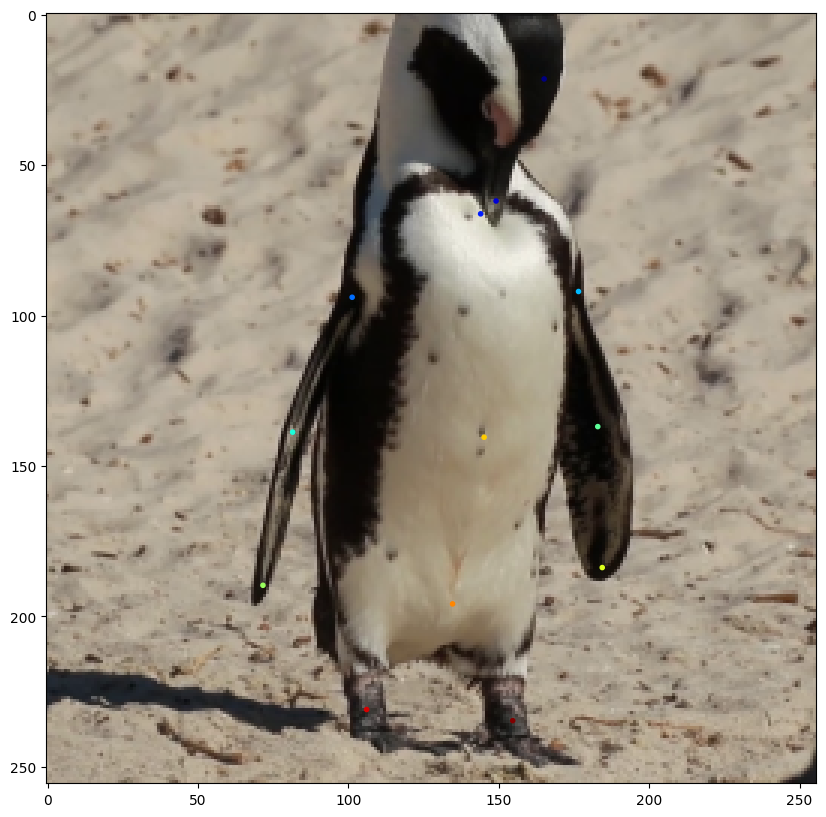

In [ ]:
display_img = 259
chosen_img = imgs_train[display_img]
chosen_img_size = chosen_img.shape
print(chosen_img_size)
#print(original_img_shape)
chosen_img_keypoints = keypoints_train[display_img]
nkeypoints = int(len(keypoints_train[0])/2)

display_keypoints = unnorm_keypoints(chosen_img_size, chosen_img_keypoints)

plot_img_and_keypoint(chosen_img, display_keypoints)

In [ ]:
print('train image')
img_show_train = np.random.choice(len(ids_train),3)

train image


#### Learning Outcomes (in order)

* Loading a dataset and annotations
* Cropping an image from a bounding box
* Resizing an image in order to be used a PE algorithm (255x255)
* Adjusting annotations for new image size


<br><br>

## Create out Test, Train and Val Datasets##
So now we have all our annotations and ids in lists, it is time to create the datasets for test, train and val.

I am going to start with very small datasets to check it out

## Building a Model ##

In [ ]:
#First we must adjust the mean_squared_error loss function to dicount the invisible keypoints (not count them)
def masked_mse(y_true, y_pred):
    # Create a mask where keypoints are visible
    # Assuming that -1 indicates an invisible keypoint
    mask = tf.not_equal(y_true, -10.0)
    #mask = tf.not_equal(y_true, np.nan)

    # Convert the mask to the same dtype as y_pred
    mask = tf.cast(mask, y_pred.dtype)

    # Apply the mask to filter out invisible keypoints from both
    # the predictions and the true values
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)

    # Compute the Mean Squared Error only on the visible keypoints
    loss = tf.keras.losses.mean_squared_error(y_true_masked, y_pred_masked)
    return loss

In [ ]:
# we need to do the same for the mse and mean absolute error metrics
def masked_mse_metric(y_true, y_pred):
    mask = tf.not_equal(y_true, -10.0)
    #mask = tf.not_equal(y_true, np.nan)
    mask = tf.cast(mask, y_pred.dtype)

    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)

    return tf.reduce_mean(tf.square(y_true_masked - y_pred_masked))

def masked_mae_metric(y_true, y_pred):
    mask = tf.not_equal(y_true, -1.0)
    #mask = tf.not_equal(y_true, np.nan)
    mask = tf.cast(mask, y_pred.dtype)

    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)

    return tf.reduce_mean(tf.abs(y_true_masked - y_pred_masked))


In [ ]:
INPUT_SHAPE = (256,256,3)

#VGG-16 Style Architecture

# Starting point
model = Sequential()

# Create one convolutional layer
model.add(Conv2D(filters = 16, kernel_size = 3, input_shape = INPUT_SHAPE, activation = 'relu'))

# Create one max pooling layer
model.add(MaxPool2D(pool_size = 2))

# Create another convolutional layer
model.add(Conv2D(filters = 32, kernel_size = 3, activation = 'relu'))

# Create another max pooling layer
model.add(MaxPool2D(pool_size=2))

# Create another convolutional layer
model.add(Conv2D(filters = 64, kernel_size = 3, activation = 'relu'))

# Create another max pooling layer
model.add(MaxPool2D(pool_size=2))

# Create another convolutional layer
model.add(Conv2D(filters = 128, kernel_size = 3, activation = 'relu'))

# Create another max pooling layer
model.add(MaxPool2D(pool_size=2))

# Create another convolutional layer
model.add(Conv2D(filters = 256, kernel_size = 3, activation = 'relu'))

# Create another max pooling layer
model.add(MaxPool2D(pool_size=2))

model.add(Flatten())

# Here we create 512 fully connected units
model.add(Dense(units = 512, activation='relu'))

# Add some drop out to improve robustness
model.add(Dropout(0.2))

# The output
model.add(Dense(nkeypoints*2))

# Here we tell the model how to improve/update the weights
model.compile(loss=masked_mse, optimizer='adam',metrics=[masked_mse_metric, masked_mae_metric, 'accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 64)        0

In [ ]:
# Load weights if there you have saved them
weights_path = '/content/drive/MyDrive/Colab Notebooks/model_weights.h5'


In [ ]:
model.load_weights(weights_path)

In [ ]:
# reformatting to use in tensor flow
imgs_train = np.array(imgs_train).astype(np.float32)
keypoints_train = np.array(keypoints_train).astype(np.float32)
print(f'shape of the imgs_list_train{imgs_train.shape}')
print(f'shape of the keypoints_train{keypoints_train.shape}')
# reformatting to use in tensor flow
imgs_val = np.array(imgs_val).astype(np.float32)
keypoints_val = np.array(keypoints_val).astype(np.float32)
print(f'shape of the imgs_list_val{imgs_val.shape}')
print(f'shape of the keypoints_val{keypoints_val.shape}')
# reformatting to use in tensor flow
imgs_test = np.array(imgs_test).astype(np.float32)
keypoints_test = np.array(keypoints_test).astype(np.float32)
print(f'shape of the imgs_list_test{imgs_test.shape}')
print(f'shape of the keypoints_test{keypoints_test.shape}')

shape of the imgs_list_train(1542, 256, 256, 3)
shape of the keypoints_train(1542, 28)
shape of the imgs_list_val(199, 256, 256, 3)
shape of the keypoints_val(199, 28)
shape of the imgs_list_test(223, 256, 256, 3)
shape of the keypoints_test(223, 28)


In [ ]:
model.fit(imgs_train,
          keypoints_train,
          batch_size=32,
          epochs=20)

Epoch 1/20
49/49 [==============================] - 17s 96ms/step - loss: 0.0076 - masked_mse_metric: 0.0077 - masked_mae_metric: 2.2758 - accuracy: 0.6783
Epoch 2/20
49/49 [==============================] - 6s 132ms/step - loss: 0.0064 - masked_mse_metric: 0.0064 - masked_mae_metric: 2.2810 - accuracy: 0.6835
Epoch 3/20
49/49 [==============================] - 5s 107ms/step - loss: 0.0061 - masked_mse_metric: 0.0061 - masked_mae_metric: 2.2824 - accuracy: 0.6783
Epoch 4/20
49/49 [==============================] - 5s 105ms/step - loss: 0.0060 - masked_mse_metric: 0.0060 - masked_mae_metric: 2.2612 - accuracy: 0.6829
Epoch 5/20
49/49 [==============================] - 5s 109ms/step - loss: 0.0060 - masked_mse_metric: 0.0061 - masked_mae_metric: 2.2747 - accuracy: 0.6757
Epoch 6/20
49/49 [==============================] - 3s 70ms/step - loss: 0.0061 - masked_mse_metric: 0.0061 - masked_mae_metric: 2.2631 - accuracy: 0.7023
Epoch 7/20
49/49 [==============================] - 4s 78ms/step 

In [ ]:
# save your model weights
model.save_weights(weights_path)

In [ ]:
def evaluate_model_performance(model, test_data, test_labels, batch_size=32):
    """
    Evaluate the performance of a model and print out the loss and all metrics.

    Parameters:
    - model: The TensorFlow/Keras model to be evaluated.
    - test_data: Input data (features) for evaluation.
    - test_labels: Labels for the test data.
    - batch_size: Number of samples per batch of computation.
    """
    # Evaluate the model
    results = model.evaluate(test_data, test_labels, batch_size=batch_size, verbose=0)

    # Print the results
    print(f"Loss: {results[0]:.4f}")
    # Loop through the metrics
    for metric, value in zip(model.metrics_names[1:], results[1:]):  # Skipping the first ('loss') as it's already printed
        print(f"{metric.capitalize()}: {value:.4f}")

# Example usage
# Assuming you have a model, imgs_test, and keypoints_test defined
# evaluate_model_performance(model, imgs_test, keypoints_test)


In [ ]:
# Example usage
# Assuming you have a model, imgs_test, and keypoints_test defined
evaluate_model_performance(model, imgs_test, keypoints_test)

Loss: 0.0187
Masked_mse_metric: 0.0187
Masked_mae_metric: 2.7603
Accuracy: 0.6771


In [ ]:
def predict(imgs_list, keypoints, index):

  # make prediction
  predicted_keypoints = model.predict(imgs_list)
  print(predicted_keypoints.shape)

  # unnormalise the keypoints that you want to check
  img_size = (256,256,3)
  predicted_keypoints = unnorm_keypoints(img_size, predicted_keypoints[index])
  original_keypoints = unnorm_keypoints(img_size, keypoints[index])

  # display the predicted output
  print('Predicted output:')
  plot_img_and_keypoint(imgs_list[index], predicted_keypoints[index])
  print('Original output:')
  plot_img_and_keypoint(imgs_list[index], original_keypoints[index])

In [ ]:
def predict_single (index, imgs_list, keypoints):

  print(np.reshape(imgs_list[index], (1,256,256,3)).shape)
  # make prediction
  predicted_keypoints = model.predict(np.reshape(imgs_list[index], (1,256,256,3)))
  print(predicted_keypoints.shape)

  # unnormalise the keypoints that you want to check
  predicted_keypoints = unnorm_keypoints((256,256,3), predicted_keypoints[0])
  original_keypoints = unnorm_keypoints((256,256,3), keypoints[index])

  # display the predicted output
  print('Predicted output:')
  print(predicted_keypoints)
  plot_img_and_keypoint(imgs_list[index], predicted_keypoints)
  print('Original output:')
  print(original_keypoints)
  plot_img_and_keypoint(imgs_list[index], original_keypoints)

(1, 256, 256, 3)
1/1 [==============================] - 1s 831ms/step
(1, 28)
Predicted output:
[201.80752563476562, 89.39213943481445, 238.92684936523438, 86.63937377929688, 149.95908164978027, 121.93463134765625, 132.14446449279785, 145.34219551086426, 116.96945095062256, 165.73338317871094, 118.21809768676758, 167.91547393798828, 132.25926876068115, 136.8866491317749, 110.65519332885742, 180.66123962402344, 84.06485748291016, 148.60595321655273, 95.24756240844727, 122.87524032592773, 51.33623504638672, 139.54732131958008, 23.047470092773438, 162.7959098815918, 95.96931838989258, 188.86424255371094, 100.4019775390625, 196.39010620117188]


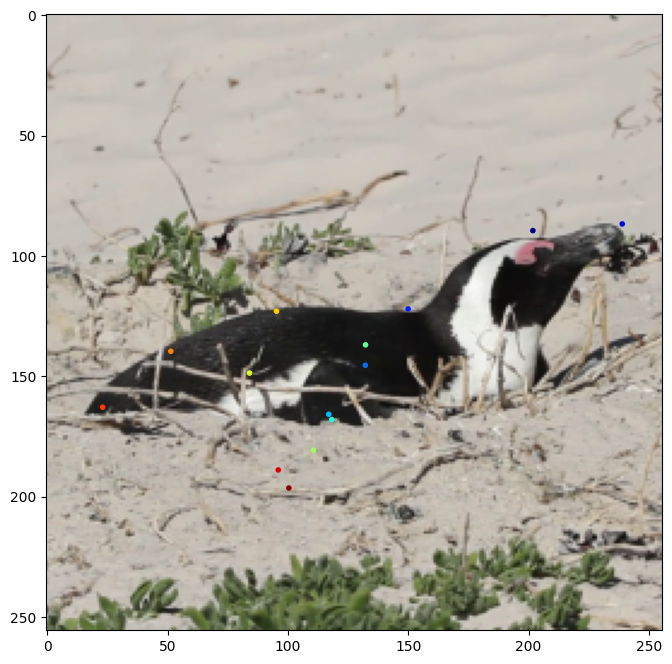

Original output:
[191.81057357788086, 95.67399597167969, 234.66666412353516, 90.0565185546875, 149.2921028137207, 125.36525011062622, 128.11818367242813, 148.39962005615234, nan, nan, 112.49686431884766, 165.9434814453125, nan, nan, nan, nan, nan, nan, 87.20843887329102, 125.62179565429688, 50.71937561035156, 142.14339065551758, 21.333335876464844, 163.24234008789062, nan, nan, nan, nan]


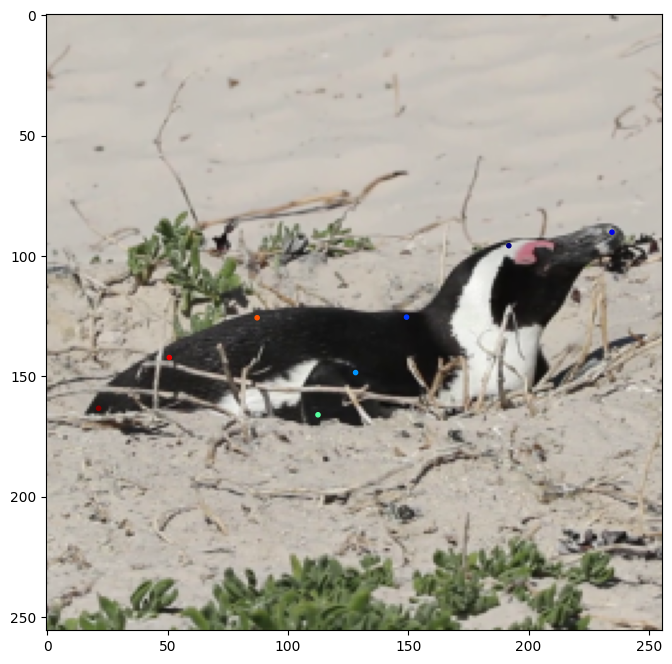

In [ ]:
predict_single(60, imgs_test, keypoints_test)